In [1]:
from importlib.metadata import version

import matplotlib
import tiktoken
import torch

print("matplotlib version:", version("matplotlib"))
print("torch version:", version("torch"))
print("tiktoken version:", version("tiktoken"))

matplotlib version: 3.10.0
torch version: 2.5.1
tiktoken version: 0.8.0


In [2]:
GPT_CONFIG_124M = {
  "vocab_size":50257 ,
  "context_length":1024,
  "emb_dim":768,
  "n_heads":12,
  "n_layers":12,
  "drop_rate":0.1,
  "qkv_bias":False
}

In [3]:
import torch 
import torch.nn as nn 

class DummyGPTModel(nn.Module):
  def __init__(self, cfg):
      super().__init__()
      self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
      self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
      self.drop_emb = nn.Dropout(cfg["drop_rate"])
      
      # Use a placeholder for TransformerBlock
      self.trf_blocks = nn.Sequential(
          *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])
      
      # Use a placeholder for LayerNorm
      self.final_norm = DummyLayerNorm(cfg["emb_dim"])
      self.out_head = nn.Linear(
          cfg["emb_dim"], cfg["vocab_size"], bias=False
      )

  def forward(self, in_idx):
      batch_size, seq_len = in_idx.shape
      tok_embeds = self.tok_emb(in_idx)
      pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
      x = tok_embeds + pos_embeds
      x = self.drop_emb(x)
      x = self.trf_blocks(x)
      x = self.final_norm(x)
      logits = self.out_head(x)
      return logits
    


class DummyTransformerBlock(nn.Module):
  def __init__(self , cfg):
    super().__init__() 
  def forward(self , x):
    return x 

class DummyLayerNorm(nn.Module):
  def __init__(self , normalized_shape,eps = 1e-5):
    super().__init__() 
  def forward(self , x):
    return x
  
    
    

In [4]:
import tiktoken 
tokenizer = tiktoken.get_encoding("gpt2")

batch = [] 
txt1 = "Every effort moves you" 
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch , dim = 0)
batch

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

In [5]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)

logits = model(batch)
logits.shape , logits

(torch.Size([2, 4, 50257]),
 tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
          [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
          [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
          [ 0.0447,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],
 
         [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
          [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
          [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
          [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
        grad_fn=<UnsafeViewBackward0>))

In [6]:
torch.manual_seed(123)
batch_example = torch.randn(2,5)

layer = nn.Sequential(nn.Linear(5,6) , nn.ReLU())
out = layer(batch_example)
out

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)

In [7]:
mean = out.mean(dim = -1 , keepdim= True)
var = out.var(dim = -1 , keepdim=  True)
mean , var

(tensor([[0.1324],
         [0.2170]], grad_fn=<MeanBackward1>),
 tensor([[0.0231],
         [0.0398]], grad_fn=<VarBackward0>))

In [8]:
out_norm = (out - mean) / torch.sqrt(var)
mean = out_norm.mean(dim = -1 , keepdim = True)
print(f"Norm Mean : { mean }")
var = out_norm.var(dim = -1 , keepdim = True)
print(f"Norm Var : {var}")

Norm Mean : tensor([[9.9341e-09],
        [5.9605e-08]], grad_fn=<MeanBackward1>)
Norm Var : tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [9]:
class LayerNorm(nn.Module):
  def __init__(self ,emb_dim):
    super().__init__() 
    self.eps = 1e-5 
    self.scale = nn.Parameter(torch.ones(emb_dim))
    self.shift = nn.Parameter(torch.zeros(emb_dim))
  def forward(self , x) :
    mean = x.mean(dim = -1 , keepdim = True)
    var = x.var(dim = -1 , keepdim = True , unbiased = False)
    norm_x = (x - mean) / torch.sqrt(var + self.eps)
    return self.scale * norm_x + self.shift
    

In [10]:
ln = LayerNorm (emb_dim = 5)
out_ln = ln(batch_example)

mean = out_ln.mean(dim = -1 , keepdim = True)
var = out_ln.var(dim= -1 , unbiased = False , keepdim = True)

mean , var

(tensor([[-2.9802e-08],
         [ 0.0000e+00]], grad_fn=<MeanBackward1>),
 tensor([[1.0000],
         [1.0000]], grad_fn=<VarBackward0>))

## 4.3 Implementing a feed forward network with GELU activations

In [11]:
class GELU(nn.Module):
  def __init__(self):
    super().__init__() 
  def forward(self , x) : 
    return 0.5 * x *(1 + torch.tanh(torch.sqrt(torch.tensor(2. / torch.pi)) * (x + 0.044715 * torch.pow(x , 2))))

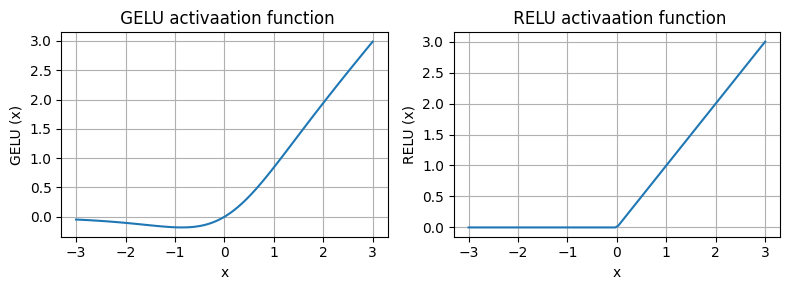

In [12]:
import matplotlib.pyplot as plt 

gelu , relu = GELU()  , nn.ReLU() 

#Some sampel data 
x = torch.linspace(-3, 3 , 100)
y_gelu , y_relu = gelu(x) , relu(x) 

plt.figure(figsize=(8,3))

for i , (y , label) in enumerate(zip([y_gelu , y_relu] , ["GELU" , "RELU"]) , 1):
  plt.subplot(1 , 2 ,i) 
  plt.plot(x , y) 
  plt.title(f" { label } activaation function")
  plt.xlabel("x")
  plt.ylabel(f"{label} (x)")
  plt.grid(True)
plt.tight_layout()
plt.show()


In [13]:
class FeedForward(nn.Module):
  def __init__(self , cfg):
    super().__init__() 
    self.layers = nn.Sequential(nn.Linear(cfg["emb_dim"] , 4 * cfg["emb_dim"]), 
                                GELU(),
                                nn.Linear(4 * cfg["emb_dim"] , cfg["emb_dim"])
                                )
  def forward(self , x):
    return self.layers(x)

In [14]:
ffn = FeedForward(GPT_CONFIG_124M) 
x = torch.rand(2,3,768) 
out = ffn(x) 
out.shape

torch.Size([2, 3, 768])

In [15]:
class ExampleDeepNeuralNetwork(nn.Module):
  def __init__(self, layer_size , use_shortcut):
    super().__init__() 
    self.use_shortcut = use_shortcut 
    self.layers = nn.ModuleList([nn.Sequential(nn.Linear(layer_size[0] ,  layer_size[1]) , GELU()) , 
                                 nn.Sequential(nn.Linear(layer_size[1] ,  layer_size[2]) , GELU()),
                                 nn.Sequential(nn.Linear(layer_size[2] ,  layer_size[3]) , GELU()),
                                 nn.Sequential(nn.Linear(layer_size[3] ,  layer_size[4]) , GELU()),
                                 nn.Sequential(nn.Linear(layer_size[4] ,  layer_size[5]) , GELU())])
  
  def forward(self , x) :
    for layer in self.layers: 
      layer_output = layer(x)
      if self.use_shortcut and x.shape == layer_output.shape:
        x = x + layer_output 
      else :
        x = layer_output 
    return x

In [16]:
def print_gradient(model , x):
  #Forward pass 
  output = model(x)
  target = torch.tensor([[0.]])
  loss = nn.MSELoss()
  loss = loss(output , target)
  loss.backward() 
  print(f"loss:{loss} ")
  for name , param in model.named_parameters(): 
    if 'weight' in name :
      print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

In [17]:
layer_sizes = [3,3,3,3,3,1]
sample_input = torch.tensor([[1.,0.,-1.]])
torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(layer_sizes , use_shortcut=False)
print_gradient(model_without_shortcut , sample_input)

loss:0.0037232250906527042 
layers.0.0.weight has gradient mean of 0.0002051283954642713
layers.1.0.weight has gradient mean of 0.00012141212937422097
layers.2.0.weight has gradient mean of 0.0007203090353868902
layers.3.0.weight has gradient mean of 0.0014052821788936853
layers.4.0.weight has gradient mean of 0.00506593007594347


In [ ]:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(
 layer_sizes, use_shortcut=True
)
print_gradient(model_with_shortcut, sample_input)

loss:0.5838012099266052 
layers.0.0.weight has gradient mean of 0.21908949315547943
layers.1.0.weight has gradient mean of 0.20527346432209015
layers.2.0.weight has gradient mean of 0.32109278440475464
layers.3.0.weight has gradient mean of 0.26618868112564087
layers.4.0.weight has gradient mean of 1.308449625968933


In [19]:
from previous_chapters import MultiHeadAttention 

class TransformerBlock(nn.Module):
  def __init__(self, cfg):
    super().__init__() 
    self.att = MultiHeadAttention(d_in = cfg["emb_dim"] , 
                                  d_out=cfg["emb_dim"] , 
                                  context_length = cfg["context_length"],
                                  num_heads = cfg["n_heads"],
                                  dropout = cfg["drop_rate"] , 
                                  qkv_bias = cfg["qkv_bias"])
    self.ff = FeedForward(cfg)
    self.norm1 = LayerNorm(cfg["emb_dim"])
    self.norm2 = LayerNorm(cfg["emb_dim"])
    self.drop_shortcut = nn.Dropout(cfg["drop_rate"])
  
  def forward(self , x):
    shortcut = x 
    x = self.norm1(x)
    x = self.att(x)
    x = self.drop_shortcut(x)
    x = x + shortcut 
    
    shortcut = x 
    x = self.norm2(x)
    x = self.ff(x)
    x = self.drop_shortcut(x)
    x = x + shortcut 
    return x
    
    

In [20]:
torch.manual_seed(123)

x = torch.rand(2, 4, 768)  # Shape: [batch_size, num_tokens, emb_dim]
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


## 4.6 Coding the GPT model 

In [21]:
class GPTModel(nn.Module):
  def __init__(self , cfg):
    super().__init__() 
    self.tok_emb = nn.Embedding(cfg["vocab_size"] , cfg["emb_dim"])
    self.pos_emb = nn.Embedding(cfg["context_length"] , cfg["emb_dim"])
    self.drop_emb = nn.Dropout(cfg["drop_rate"])
    
    self.trf_blocks = nn.Sequential(*[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
    self.final_norm = LayerNorm(cfg["emb_dim"])
    
    self.out_head = nn.Linear(cfg["emb_dim"] , cfg["vocab_size"] , bias = False)
    
  def forward(self, in_idx):
    batch_size , seq_len = in_idx.shape
    tok_embeds = self.tok_emb(in_idx)
    pos_embeds =  self.pos_emb(torch.arange(seq_len, device = in_idx.device) )
    
    x = tok_embeds + pos_embeds  
    x = self.drop_emb(x)
    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)
    return logits

In [22]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
out  = model(batch)
print("Input batch :\n" , batch)
print("\nOutput shape: " , out.shape)
out

Input batch :
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape:  torch.Size([2, 4, 50257])


tensor([[[ 0.1465,  0.0060, -0.1983,  ..., -0.0181, -0.1072,  0.1738],
         [ 0.3889, -0.8497, -0.6451,  ..., -0.5176,  0.2426, -0.3291],
         [ 0.7039, -0.1876, -0.1647,  ...,  0.1533, -0.6497, -0.0068],
         [-0.4326,  0.1618, -0.1276,  ...,  1.1563,  0.5361, -0.5506]],

        [[ 0.1190, -0.2940, -0.1513,  ..., -0.0485,  0.2952, -0.2819],
         [ 0.0933, -0.3584, -0.3508,  ...,  1.2934,  0.0025,  0.1912],
         [ 0.6031,  0.4778, -0.4075,  ...,  0.7778,  0.3806, -0.1939],
         [-0.0458, -0.0841,  0.4740,  ...,  1.2461, -0.3753,  0.0601]]],
       grad_fn=<UnsafeViewBackward0>)

In [23]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


In [24]:
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


In [25]:
total_params_gpt2 =  total_params - sum(p.numel() for p in model.out_head.parameters())
print(f"Number of trainable parameters considering weight tying: {total_params_gpt2:,}")

Number of trainable parameters considering weight tying: 124,412,160


In [26]:
total_size_bytes = total_params * 4 
total_size_mb = total_size_bytes / (1024 * 1024)
print(f"Total size of the model : {total_size_mb : .2f} MB")

Total size of the model :  621.83 MB


## 4.8 Generateing Text

In [27]:
def generate_text_simple(model , idx , max_new_tokens , context_size):
  for _ in range(max_new_tokens):
    idx_cond = idx[:, -context_size:]
    with torch.no_grad():
      logits = model(idx_cond)
    logits = logits[: , -1 , :]
    probas = torch.softmax(logits , dim = -1)
    idx_next = torch.argmax(probas , dim= - 1, keepdim = True)
    idx = torch.cat((idx , idx_next) , dim = 1)
  return idx
  

In [28]:
start_context = "Hello, I am"

encoded = tokenizer.encode(start_context)
print("encoded:", encoded)

encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


In [30]:
model.eval() # disable dropout

out = generate_text_simple(
    model=model,
    idx=encoded_tensor, 
    max_new_tokens=6, 
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output:", out)
print("Output length:", len(out[0]))

decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output length: 10
Hello, I am Featureiman Byeswickattribute argue
